## Numerical Resolution of Partial Differential Equations

### 1. We start by plotting the PDE price of the European call in the Black & Scholes model as a function of S0, then we plot the difference between the PDE price and the exact price from the Black & Scholes formula as a function of S0.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

In [2]:
# Model and grid parameters
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2

# Numerical meshing parameters
M = 100       # Number of time steps
N = 1000      # Number of space steps
L = np.log(3*K) # Artificial boundary (L >> log K)

In [3]:
# Black & Scholes formula
def black_scholes_call(S, K, T, r, sigma):
    S = np.maximum(S, 1e-10)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

## **Finite Differences:**

We start from the Black & Scholes PDE: $$\frac{\partial u}{\partial t}(t,x) + r x \frac{\partial u}{\partial x}(t,x) + \frac{1}{2} \sigma^2 x^2 \frac{\partial^2 u}{\partial x^2}(t,x) = r u(t,x)$$

I. Change of variables: τ=T−t\tau = T - t
τ=T−t and y=log(x)y = log(x)
y=log(x)
We obtain, $$\frac{\partial u}{\partial \tau} = \frac{\sigma^{2}}{2}\frac{\partial^{2}u}{\partial y^{2}} + (r-\frac{\sigma^{2}}{2})\frac{\partial u}{\partial y} - ru$$




**II. Spatial discretization:** $h=\frac{2L}{N}$

We define A,B such that: $\frac{\partial U}{\partial \tau} = A*U(\tau) + B$

We inject a numerical approximation into the PDE: $\frac{\partial^{2}u}{\partial y^{2}} \approx \frac{u_{i+1} - 2u_i + u_{i-1}}{h^2}$ et  $\frac{\partial u}{\partial y} \approx \frac{u_{i+1} - u_{i-1}}{2h}$

hence,

$\text{Coeff}_{i+1} = \left( \frac{\sigma^2}{2} \times \frac{1}{h^2} \right) + \left( (r - \frac{\sigma^2}{2}) \times \frac{1}{2h} \right) = \frac{\sigma^2}{2h^2} + \frac{r - \frac{\sigma^2}{2}}{2h}$

$\text{Coeff}_{i} = \left( \frac{\sigma^2}{2} \times \frac{-2}{h^2} \right) - r = -\frac{\sigma^2}{h^2} - r$

$\text{Coeff}_{i-1} = \left( \frac{\sigma^2}{2} \times \frac{1}{h^2} \right) + \left( (r - \frac{\sigma^2}{2}) \times \frac{-1}{2h} \right)  \frac{\sigma^2}{2h^2} - \frac{r - \frac{\sigma^2}{2}}{2h}$

**III. Time discretization:** $\Delta T=\frac{T}{M}$

$$U^{j+1} - U^j = \Delta T (A U^{j+1}+B)$$

Then,

$$U^{j} + B\Delta T = (I - \Delta T A) U^{j+1}$$

(We choose the implicit Euler scheme as it is more stable (no need for numerical inversion).

**IV. Boundary conditions**

Dirichlet conditions: (we fix u at the boundaries)

S -> 0  => $u = 0$

S -> +$\inf$ => $u = S - K e^{-r\tau}$

Finally we solve numerically,

$$\begin{pmatrix}
\beta & \gamma & 0 & \cdots & 0 \\
\alpha & \beta & \gamma & \cdots & 0 \\
0 & \alpha & \beta & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & \gamma \\
0 & \cdots & 0 & \alpha & \beta
\end{pmatrix}
\begin{pmatrix}
u_1^{j+1} \\
u_2^{j+1} \\
u_3^{j+1} \\
\vdots \\
u_{N-1}^{j+1}
\end{pmatrix}
=
\begin{pmatrix}
u_1^j \\
u_2^j \\
u_3^j \\
\vdots \\
u_{N-1}^j
\end{pmatrix}
+
\begin{pmatrix}
\Delta \tau \cdot a_{\text{down}} \cdot u_0^{j+1} \\
0 \\
0 \\
\vdots \\
\Delta \tau \cdot a_{\text{up}} \cdot u_N^{j+1}
\end{pmatrix}$$

In [4]:
def solve_bs_pde(S0, K, T, r, sigma, N, M, L):
    """
    Solve PDE using Finite Differences.
    """
    # Create local grid
    dt = T / M
    dy = 2 * L / N
    y = np.linspace(-L, L, N+1)
    S_grid = np.exp(y)

    # Coefficients of operator A
    sig2 = sigma**2

    A_c = (sig2 / (2 * dy**2)) + ((r - sig2 / 2) / (2 * dy))
    A_b = - (sig2 / dy**2) - r
    A_a = (sig2 / (2 * dy**2)) - ((r - sig2 / 2) / (2 * dy))

    # Construct matrix A
    diagonals = [np.ones(N-1)*A_a, np.ones(N-1)*A_b, np.ones(N-1)*A_c]
    A = sparse.diags(diagonals, [-1, 0, 1], shape=(N-1, N-1), format="csc")

    # Implicit system matrix : (I - dt * A)
    I = sparse.eye(N-1)
    M_sys = I - dt * A

    # Initial Condition (Payoff at t=T, so tau=0)
    U = np.maximum(S_grid[1:N] - K, 0) # We only take interior points

    # Time loop (from tau=0 to T)
    for j in range(M):
        # Boundary conditions (Dirichlet)
        tau = (j + 1) * dt

        # Left boundary (S -> 0 => y -> -L) : Call is 0
        boundary_left = 0

        # Right boundary (S -> inf => y -> L) : Call is S - K*exp(-r*tau)
        boundary_right = S_grid[N] - K * np.exp(-r * tau)

        # Add boundary terms that 'enter' the matrix
        b = U.copy()
        b[0] += dt * A_a * boundary_left
        b[-1] += dt * A_c * boundary_right

        # Solve the linear system
        U = spsolve(M_sys, b)

    # Reconstruct the full vector (with boundaries) for display
    U_final = np.zeros(N+1)
    U_final[1:N] = U
    U_final[0] = 0
    U_final[-1] = S_grid[N] - K * np.exp(-r * T)

    return S_grid, U_final


S_grid, U_final = solve_bs_pde(S0, K, T, r, sigma, N, M, L)
BS_exact = black_scholes_call(S_grid, K, T, r, sigma)

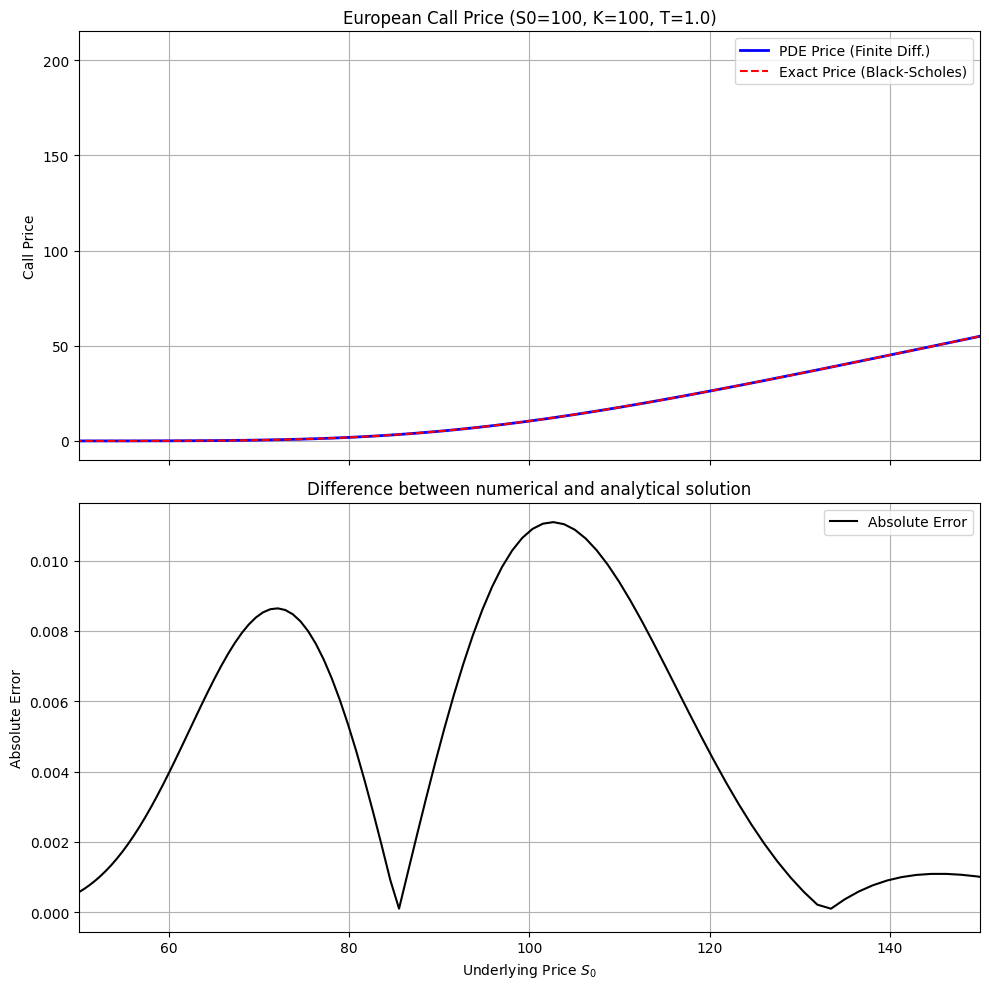

In [5]:
# Plots

# Calculate the exact solution on the grid
BS_exact = black_scholes_call(S_grid, K, T, r, sigma)

# Create the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot 1: PDE Price vs Exact Price
ax1.plot(S_grid, U_final, 'b-', label='PDE Price (Finite Diff.)', linewidth=2)
ax1.plot(S_grid, BS_exact, 'r--', label='Exact Price (Black-Scholes)', linewidth=1.5)
ax1.set_ylabel('Call Price')
ax1.set_title(f'European Call Price (S0={S0}, K={K}, T={T})')
ax1.legend()
ax1.grid(True)
# Zoom around the strike to see better
ax1.set_xlim(K*0.5, K*1.5)

# Plot 2: Error (PDE Price - Exact Price)
error = np.abs(U_final - BS_exact)
ax2.plot(S_grid, error, 'k-', label='Absolute Error')
ax2.set_xlabel('Underlying Price $S_0$')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Difference between numerical and analytical solution')
ax2.legend()
ax2.grid(True)
ax2.set_xlim(K*0.5, K*1.5) # Same zoom

plt.tight_layout()
plt.show()

We observe that the numerical resolution is very close to the Black and Scholes formula. +-0.011 at most for a rather coarse mesh.

### 2. We plot the error in norm ‖ · ‖∞ of the PDE price vector as a function of N (with M sufficiently large and fixed).

In [6]:
# Spatial Convergence

# Parameters
M_fixed = 2000
N_values = [50, 100, 200, 400, 800, 1600] # Double N each time
errors_space = []

print(f"Spatial convergence analysis (M fixed at {M_fixed})...")

for N_val in N_values:
    S_grid_N, U_edp_N = solve_bs_pde(S0, K, T, r, sigma, N_val, M_fixed, L)
    BS_exact_N = black_scholes_call(S_grid_N, K, T, r, sigma)
    error_inf = np.max(np.abs(U_edp_N - BS_exact_N))
    errors_space.append(error_inf)

    print(f"N={N_val:4d} | Max Error={error_inf:.2e}")

Spatial convergence analysis (M fixed at 2000)...
N=  50 | Max Error=4.82e-01
N= 100 | Max Error=1.13e-01
N= 200 | Max Error=2.62e-02
N= 400 | Max Error=8.37e-03
N= 800 | Max Error=4.31e-03
N=1600 | Max Error=1.30e-03


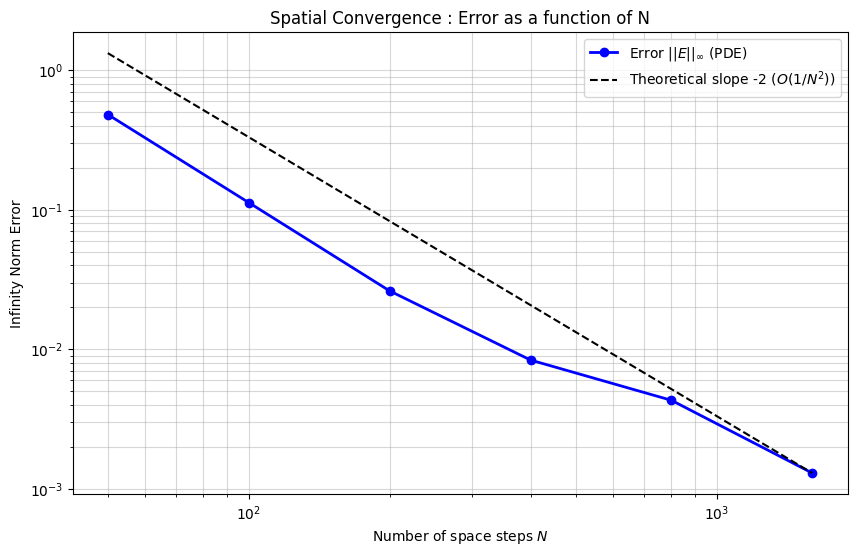

Observed empirical slope : -1.73


In [7]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.loglog(N_values, errors_space, 'bo-', label=r'Error $||E||_{\infty}$ (PDE)', linewidth=2)
C = errors_space[-1] * (N_values[-1]**2)
ref_y = [C * (n**-2) for n in N_values]
plt.loglog(N_values, ref_y, 'k--', label=r'Theoretical slope -2 ($O(1/N^2)$)')

plt.title("Spatial Convergence : Error as a function of N")
plt.xlabel("Number of space steps $N$")
plt.ylabel("Infinity Norm Error")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

# Calculate the final slope for verification
pente = np.log(errors_space[-1]/errors_space[-2]) / np.log(N_values[-1]/N_values[-2])
print(f"Observed empirical slope : {pente:.2f}")

The spatial convergence error does converge to 0 as N tends to +inf. Moreover, the convergence rate matches the theoretical convergence rate of O(1N2)O\left(\frac{1}{N^2}\right)
O(N21​) when N becomes large.


### 3. We plot the error in norm ‖ · ‖∞ of the PDE price vector as a function of M (with N sufficiently large and fixed).

In [8]:
# Temporal Convergence

# Parameters
N_fixed = 5000
M_values = [10, 20, 40, 80, 160, 320] # Double M each time
errors_time = []

print(f"Temporal convergence analysis (N fixed at {N_fixed})...")

for M_val in M_values:
    S_loc, U_edp = solve_bs_pde(S0, K, T, r, sigma, N_fixed, M_val, L)
    BS_exact = black_scholes_call(S_loc, K, T, r, sigma)
    error_inf = np.max(np.abs(U_edp - BS_exact))
    errors_time.append(error_inf)
    print(f"M={M_val:3d} | Max Error={error_inf:.2e}")

Temporal convergence analysis (N fixed at 5000)...
M= 10 | Max Error=1.06e-01
M= 20 | Max Error=5.34e-02
M= 40 | Max Error=2.68e-02
M= 80 | Max Error=1.34e-02
M=160 | Max Error=6.69e-03
M=320 | Max Error=3.35e-03


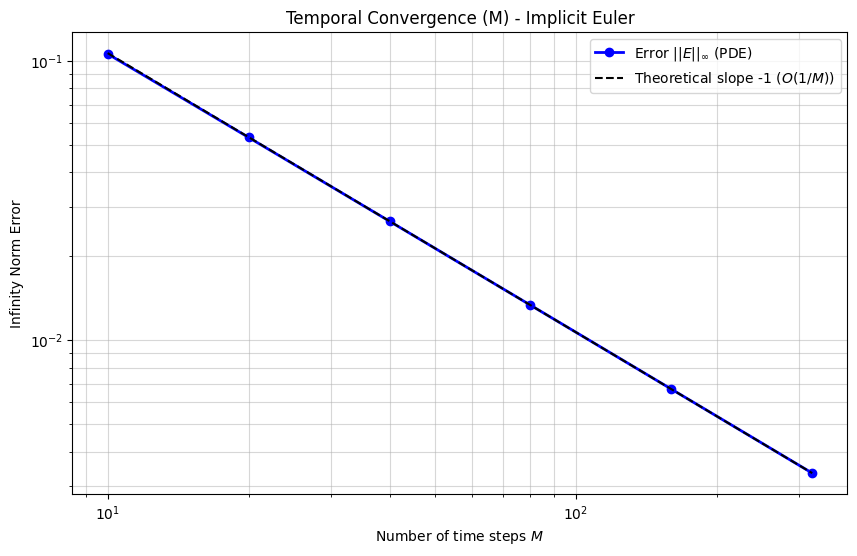

Observed empirical slope : -1.00


In [9]:
# Plot
plt.figure(figsize=(10, 6))


plt.loglog(M_values, errors_time, 'bo-', label=r'Error $||E||_{\infty}$ (PDE)', linewidth=2)
C = errors_time[-1] * M_values[-1]
ref_y = [C * (m**-1) for m in M_values]
plt.loglog(M_values, ref_y, 'k--', label=r'Theoretical slope -1 ($O(1/M)$)')

plt.title("Temporal Convergence (M) - Implicit Euler")
plt.xlabel("Number of time steps $M$")
plt.ylabel("Infinity Norm Error")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# Calculate the final slope for verification
pente_time = np.log(errors_time[-1]/errors_time[-2]) / np.log(M_values[-1]/M_values[-2])
print(f"Observed empirical slope : {pente_time:.2f}")

Unlike spatial convergence, temporal convergence is exactly $O\left(\frac{1}{M}\right)$.

### 4. We plot the pointwise error $|u_{i}^{j}-u(j\Delta T,y_{i})|$  as a function of $t=T-j\Delta T\in[0,T]$ et $S=e^{y_{i}}\in[e^{-L},e^{L}]$.

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [11]:
# Parameters for 3D plot
N_plot = 100
M_plot = 100
S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
L = np.log(3*K)

# PDE Resolution with Full Storage of all vectors
dt = T / M_plot
dy = 2 * L / N_plot
y = np.linspace(-L, L, N_plot+1)
S_grid = np.exp(y)

# Coefficients
sig2 = sigma**2
a_up = (sig2 / (2 * dy**2)) + ((r - sig2 / 2) / (2 * dy))
a_center = - (sig2 / dy**2) - r
a_down = (sig2 / (2 * dy**2)) - ((r - sig2 / 2) / (2 * dy))

diagonals = [np.ones(N_plot-1)*a_down, np.ones(N_plot-1)*a_center, np.ones(N_plot-1)*a_up]
A = sparse.diags(diagonals, [-1, 0, 1], shape=(N_plot-1, N_plot-1), format="csc")
M_sys = sparse.eye(N_plot-1) - dt * A

# Initialize the surface matrix (Time x Space)
U_surface = np.zeros((M_plot + 1, N_plot + 1))
U_surface[0, :] = np.maximum(S_grid - K, 0) # Initial condition (tau=0 => t=T)

# Current vector (for calculation)
U = U_surface[0, 1:N_plot].copy()

# Initialize the surface matrix (Time x Space)
# Dimensions : (M+1) instants x (N+1) space points
U_surface = np.zeros((M_plot + 1, N_plot + 1))
U_surface[0, :] = np.maximum(S_grid - K, 0) # Initial condition (tau=0 => t=T)

# Current vector (for calculation)
U = U_surface[0, 1:N_plot].copy()

# Time Loop with recording
for j in range(M_plot):
    tau = (j + 1) * dt

    boundary_left = 0
    boundary_right = S_grid[N_plot] - K * np.exp(-r * tau)

    b = U.copy()
    b[0] += dt * a_down * boundary_left
    b[-1] += dt * a_up * boundary_right

    U = spsolve(M_sys, b)

    # Store the result in the matrix (with boundaries)
    U_surface[j+1, 1:N_plot] = U
    U_surface[j+1, 0] = boundary_left
    U_surface[j+1, -1] = boundary_right


# Calculate the Error over the entire surface
tau_vals = np.linspace(0, T, M_plot + 1)
S_mesh, Tau_mesh = np.meshgrid(S_grid, tau_vals)

BS_surface = black_scholes_call(S_mesh, K, Tau_mesh, r, sigma)

# Absolute error
Error_surface = np.abs(U_surface - BS_surface)

/tmp/ipython-input-3721907741.py:4: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


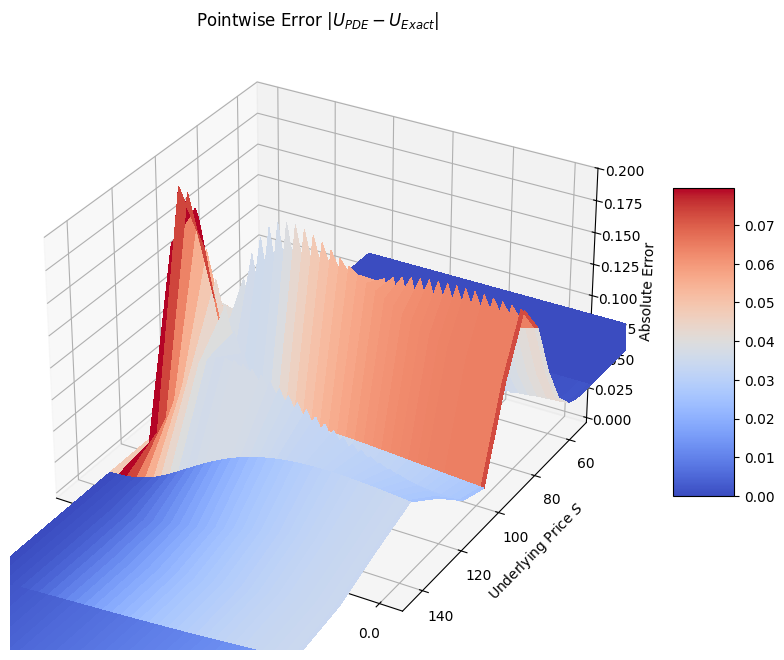

In [12]:
# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

t_mesh = T - Tau_mesh # Convert tau to t

# Surface plot
surf = ax.plot_surface(t_mesh, S_mesh, Error_surface, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_title("Pointwise Error $|U_{PDE} - U_{Exact}|$")
ax.set_xlabel("Time $t$ (years)")
ax.set_ylabel("Underlying Price $S$")
ax.set_zlabel("Absolute Error")
ax.view_init(elev=30, azim=120) # View angle to clearly see the peak
fig.colorbar(surf, shrink=0.5, aspect=5)

# Zoom in on the interesting area (around the Strike)
ax.set_ylim(K*0.5, K*1.5)

plt.show()

We observe a very pronounced error ridge at price S=K. This problem comes from the discontinuity of the Payoff at S = K.


$$Payoff(S) = \max(S - K, 0)$$

Over the rest of the surface, the numerical method converges very well to the exact solution.
